In [129]:
# !pip install networkx
# !pip install pydot

In [161]:
%%time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import pandas as pd
from shapely.geometry import Point, LineString
from collections import defaultdict
import matplotlib.pyplot as plt
from colour import Color
import os
from scipy.stats.stats import pearsonr   
import csv
import seaborn as sns
import geopy.distance
from sklearn.datasets import make_blobs
from diameter_clustering import MaxDiameterClustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import copy
from operator import truediv
import math
import networkx as nx
import seaborn as sns
import operator
from shapely import wkt


CPU times: total: 0 ns
Wall time: 0 ns


<timed exec>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.


### Reading files

In [6]:
DC = gpd.read_file("Washington_DC_Boundary.geojson")
taxi_jan = pd.read_csv('taxi_2021_01.csv')

#Parsing dates in the dataframe
taxi_jan['ORIGINDATETIME_TR'] =  pd.to_datetime(taxi_jan['ORIGINDATETIME_TR'], format='%m/%d/%Y %H:%M')

### Making grid on the map

C:\Python310\lib\site-packages\geopandas\geodataframe.py:2352: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.overlay(


CPU times: total: 8.92 s
Wall time: 8.96 s


[]

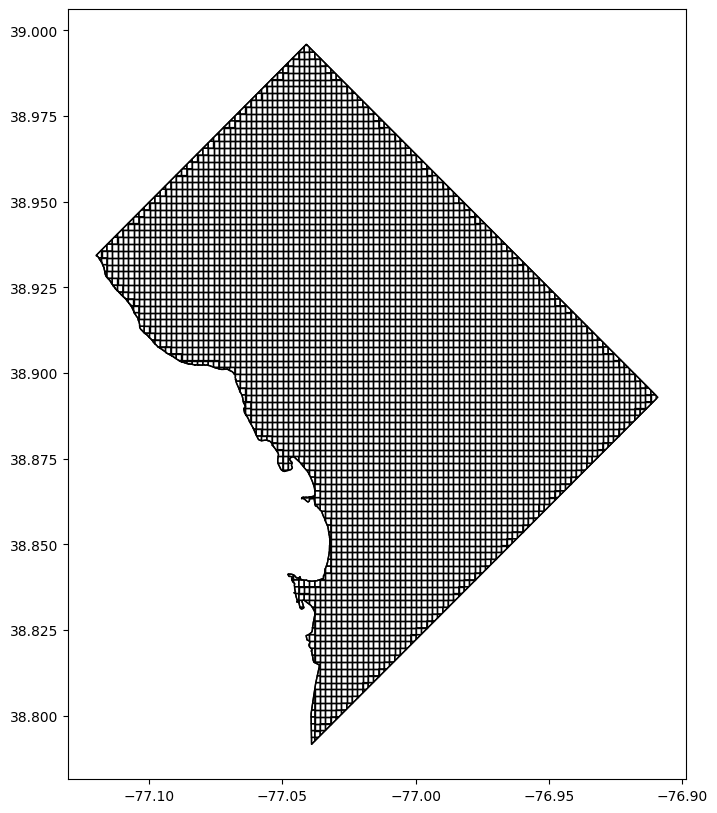

In [154]:
%%time

#Defining grid borders
xmin, ymin, xmax, ymax = DC.total_bounds

#Defining grid size by latitude and longitude area
length = 0.002
wide = 0.002

#Making list of coordinates for squares to be formed
cols = list(np.arange(xmin, xmax+(0*wide), wide))
rows = list(np.arange(ymin, ymax+(1*length), length))

#Making list of the polygons formed from the list of coordinates
polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

#Making the grid of those polygons
grid = gpd.GeoDataFrame({'geometry':polygons})

#PLot the grid
# grid.boundary.plot(figsize=(5, 5))

res_intersection = DC.overlay(grid, how='intersection')

#Plot the grid on the map
ax = res_intersection.plot(facecolor='none', figsize=(10, 10))
ax = DC.plot(ax=ax, facecolor='none',edgecolor='k')
ax.plot(ax=ax)

### Data pre-processing

In [8]:
#Extracting data of Monday 15:00 from the dataframe
taxi_jan_Monday_15 = taxi_jan[(taxi_jan['ORIGINDATETIME_TR'].dt.strftime("%A") == 'Monday') & (taxi_jan['ORIGINDATETIME_TR'].dt.strftime("%H") == "15")]

In [9]:
#List of the sources from the map
sources = [] 
#List of the destination from the map
dests = []
#List of both source and destination from the map
s_d_points = []
#Dictionary of source and destination
"""
Structure of the dictionary:

{source1: {destination1: "number of trips from source1->destination1",
           destination5: "number of trips from source1->destination5",
           .
           .
           .
           destination7: "number of trips from source1->destination7",},
.
.
.
.
.
source2: {destination2: "number of trips from source1->destination1",
          destination6: "number of trips from source1->destination6",
          .
          .
          .
          .
          destination3: "number of trips from source1->destination3",}
}
"""
squares_chloropath = defaultdict(lambda: defaultdict(int))
for index, row in taxi_jan_Monday_15.iterrows():
    point = Point(row.ORIGIN_BLOCK_LONGITUDE,row.ORIGIN_BLOCK_LATITUDE)
    for index1, square1 in enumerate(polygons):
        if square1.contains(point):
            sources.append(index1)
            s_d_points.append(index1)
            #print("true")
            dest = Point(row.DESTINATION_BLOCK_LONG,row.DESTINATION_BLOCK_LAT)
            for index2, square2 in enumerate(polygons):
                if square2.contains(dest):
                    if(index1 != index2):
                        squares_chloropath[index1][index2]+=1
                    dests.append(index2)
                    s_d_points.append(index2)

In [10]:
#Making a dictionary for assigning 0 to N ids instead of indexes of polygons
"""
Explanation:

The locations are basically the grid boxes in the map,
and we have named them based on the indexes of the list 
of those polygons which form the grid but the 
google OR tool takes locations in a particular way which 
requires location IDs to be in the range of 0 to N where N are the number of the grids,
thus we have mapped indexes of polygons
to the list of the integer from 0 to N
"""

s_d_point_dict = {}
number = 0
for s_d_point in s_d_points:
    if(s_d_point_dict.get(s_d_point, "None") == "None"):
        s_d_point_dict[s_d_point] = number
        number = number + 1
        
#-----------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------
        
#Sanity Check - to see if all the unique locations are included in the dictionary

source_dict = {}
dest_dict = {}

number = 0
for source in sources:
    source_dict[number] = source
    number = number + 1

number = 0
for dest in dests:
    dest_dict[number] = dest
    number = number + 1
    
number = 0
for i in dest_dict:
    if(s_d_point_dict.get(dest_dict[i], None) == None):
        number = number + 1


for i in source_dict:
    if(s_d_point_dict.get(source_dict[i], None) == None):
        number = number + 1

if(number == 0):
    print("Sanity check passed")

Sanity check passed


In [11]:
#Making list for OR-Tools
#List of pickup and deliveries

matrix_pickup_delivery = []
for source in squares_chloropath:
    for dest in squares_chloropath[source]:
        matrix_pickup_delivery.append([s_d_point_dict.get(source), s_d_point_dict.get(dest)])

In [12]:
#Distance matrix between the polygons

dist_y = [None] *len(s_d_point_dict)
for y_axis in s_d_point_dict:
    dist_x = [None] *len(s_d_point_dict)
    y_polygon = polygons[y_axis]
    for x_axis in s_d_point_dict:
        x_polygon = polygons[x_axis]
        dist_x[s_d_point_dict[x_axis]] = int(2*geopy.distance.geodesic((y_polygon.centroid.y, y_polygon.centroid.x), (x_polygon.centroid.y, x_polygon.centroid.x)).km)
    dist_y[s_d_point_dict[y_axis]] = dist_x

In [13]:
#Print list of pickup and deliveries
print(matrix_pickup_delivery)

[[0, 1], [0, 91], [0, 161], [0, 259], [0, 291], [0, 330], [0, 61], [0, 391], [0, 409], [0, 247], [0, 583], [3, 4], [3, 10], [3, 50], [3, 64], [3, 78], [3, 48], [3, 93], [3, 52], [3, 92], [3, 137], [3, 188], [3, 192], [3, 28], [3, 290], [3, 326], [3, 348], [3, 364], [3, 374], [3, 51], [3, 295], [3, 384], [3, 398], [3, 292], [3, 446], [3, 459], [3, 198], [3, 74], [3, 410], [3, 317], [3, 506], [3, 379], [3, 587], [3, 599], [3, 391], [5, 6], [5, 16], [5, 38], [5, 54], [5, 39], [5, 278], [5, 150], [5, 301], [5, 367], [5, 432], [5, 210], [5, 531], [5, 505], [5, 598], [7, 8], [7, 149], [7, 258], [7, 281], [7, 97], [7, 462], [7, 526], [7, 513], [11, 12], [13, 14], [15, 3], [17, 18], [19, 20], [21, 22], [23, 24], [23, 33], [25, 26], [27, 28], [27, 156], [27, 525], [27, 108], [29, 30], [29, 87], [31, 32], [34, 35], [36, 37], [39, 40], [39, 585], [41, 42], [41, 63], [41, 134], [41, 22], [41, 116], [43, 44], [43, 383], [45, 46], [47, 48], [47, 76], [47, 134], [47, 530], [51, 3], [51, 117], [51, 22

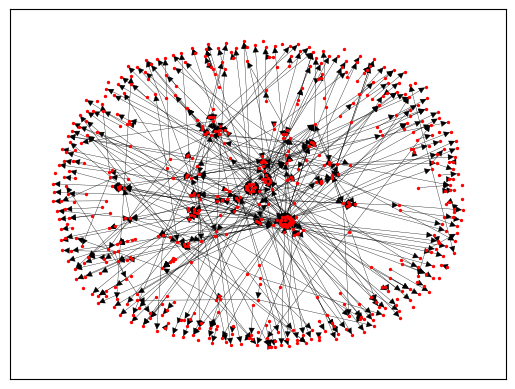

In [73]:
G = nx.DiGraph()
nodes = np.arange(0, 606).tolist()

G.add_nodes_from(nodes)
G.add_edges_from(matrix_pickup_delivery)
nx.draw_networkx(G, arrows = True, node_shape = "o", node_color = "red",with_labels=False, node_size=2, width=0.25)

In [57]:
# node degree calculation
node_indegrees=[item for item in dict(G.in_degree()).items()]
node_outdegrees=[item for item in dict(G.out_degree()).items()]
sorted_indegrees=sorted(node_indegrees,key=operator.itemgetter(1),reverse=True)
sorted_outdegrees=sorted(node_outdegrees,key=operator.itemgetter(1),reverse=True)

print("Sample Indegree List",node_indegrees[:5],"\n")
print("Sorted In Decreasing Order of Indegrees",sorted_indegrees[:5],"\n")
print("Sample Outdegree List",node_outdegrees[:5],"\n")
print("Sorted In Decreasing Order of Outdegree",sorted_outdegrees[:5],"\n")

Sample Indegree List [(0, 13), (1, 1), (2, 0), (3, 36), (4, 1)] 

Sorted In Decreasing Order of Indegrees [(3, 36), (0, 13), (39, 8), (24, 7), (48, 7)] 

Sample Outdegree List [(0, 11), (1, 0), (2, 1), (3, 34), (4, 0)] 

Sorted In Decreasing Order of Outdegree [(3, 34), (5, 14), (0, 11), (7, 8), (49, 7)] 



In [58]:
node_degrees=[item for item in dict(G.degree()).items()]

C:\Users\Jignasu\AppData\Local\Temp\ipykernel_26084\3324095993.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.Series(np.array(node_degrees).T[1], name="Degree distribution"))


<AxesSubplot: xlabel='Degree distribution', ylabel='Density'>

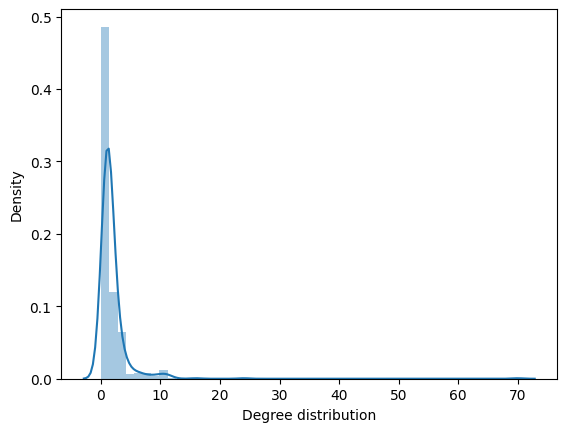

In [59]:
sns.distplot(pd.Series(np.array(node_degrees).T[1], name="Degree distribution"))

Text(0.5, 0, 'Rank')

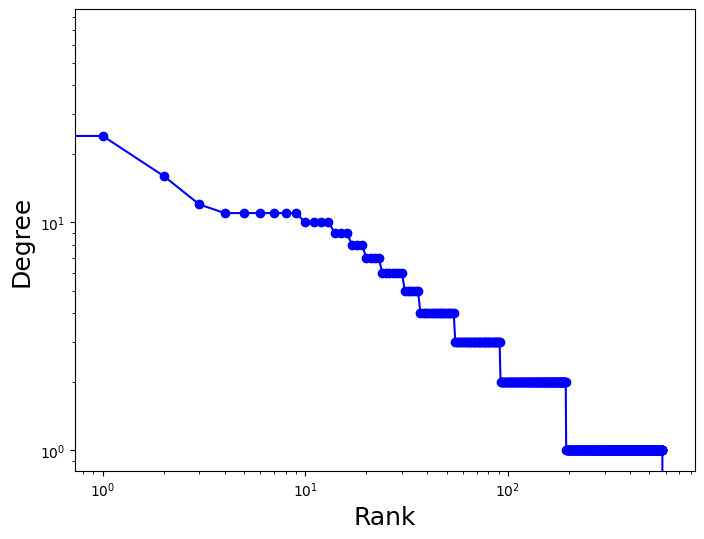

In [60]:
deg=list(sorted(dict(nx.degree(G)).values(),reverse=True)) 
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.loglog(deg,'b-',marker='o')
ax.set_ylabel('Degree',fontsize=18)
ax.set_xlabel('Rank',fontsize=18)

<AxesSubplot: title={'center': 'Closeness centrality scores'}, ylabel='Frequency'>

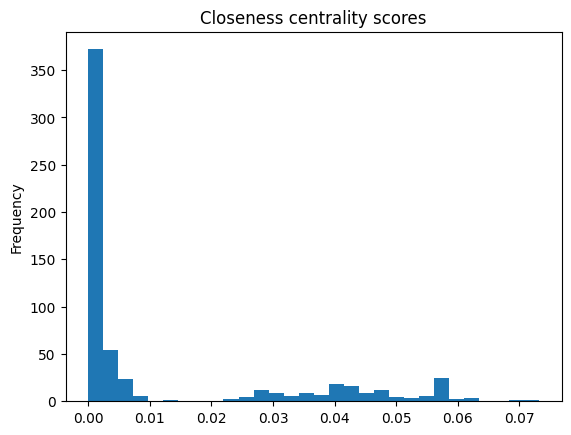

In [61]:
pd.Series(nx.closeness_centrality(G)).sort_values().plot(kind='hist',bins=30,title="Closeness centrality scores")

<AxesSubplot: title={'center': 'Betweenness centrality scores'}, ylabel='Frequency'>

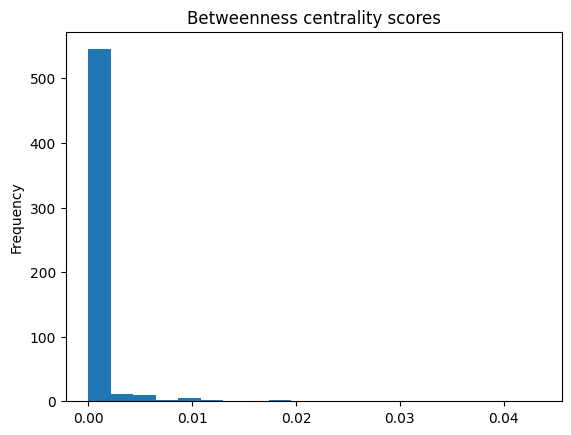

In [85]:
pd.Series(nx.betweenness_centrality(G1)).sort_values().plot(kind='hist',bins=20,title="Betweenness centrality scores")

In [62]:
hubs,authorities=nx.hits(G)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])

Top 10 Biggest Hubs [(94, 0.028248978634141664), (116, 0.027676345494988215), (163, 0.026909279413675786), (314, 0.026909279413675786), (137, 0.026844801347187974), (438, 0.02673896885954261), (51, 0.0267250488363038), (492, 0.026293507063934827), (445, 0.02592726709667159), (66, 0.025926852469487303)]

Top 10 Biggest Authorities [(3, 0.4149951896896763), (94, 0.028138916372230458), (48, 0.024868338468794396), (0, 0.017998558262105044), (87, 0.014405632369324956), (38, 0.014302017120167152), (301, 0.013608346433695878), (108, 0.01334516947064993), (22, 0.013122180028351254), (65, 0.012775093400095522)]


C:\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Number of Strongly Connected Components 565 
Sample Strongly Connected Components [[1], [91], [161]]


Text(0, 0.5, 'Number of Nodes Per Component')

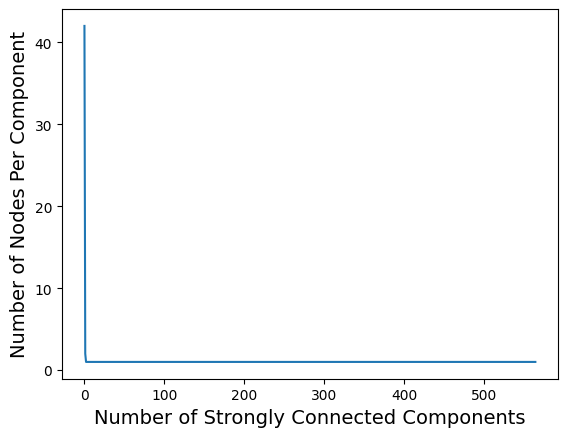

In [74]:
#Strongly Connected Components    
scc=[list(l) for l in nx.strongly_connected_components(G)]  #Strongly Connected Components
print("Number of Strongly Connected Components",len(scc),"\nSample Strongly Connected Components",scc[:3])
plt.plot(list(sorted(map(lambda x: len(x),scc),reverse=True)))
plt.xlabel("Number of Strongly Connected Components",fontsize=14)
plt.ylabel("Number of Nodes Per Component",fontsize=14)

Number of Weakly Connected Components 100 
Sample Weakly Connected Components [[0, 1, 3, 4, 5, 6, 7, 8, 10, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 114, 116, 117, 118, 124, 125, 134, 135, 136, 137, 138, 139, 140, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 159, 160, 161, 162, 163, 166, 167, 168, 171, 172, 175, 176, 177, 183, 184, 185, 186, 187, 188, 191, 192, 198, 199, 202, 203, 204, 209, 210, 211, 216, 217, 218, 221, 222, 223, 224, 226, 227, 228, 232, 233, 234, 237, 240, 242, 243, 245, 246, 247, 248, 251, 252, 253, 256, 257, 258, 259, 261, 262, 265, 266, 267, 271, 272, 275, 276, 277, 278, 281, 282, 283, 284, 285, 287, 290, 291, 292, 293, 294, 295, 296, 301, 302, 303, 

Text(0, 0.5, 'Number of Nodes Per Component')

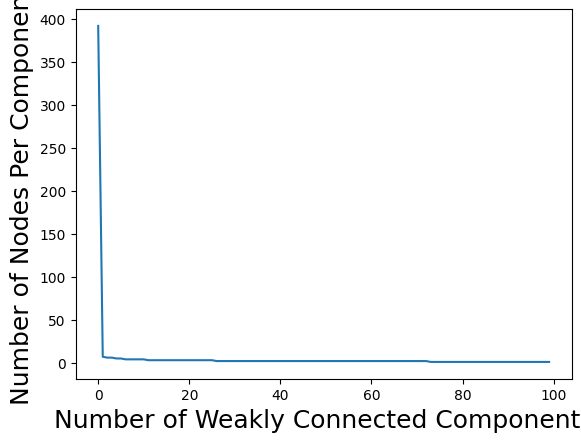

In [75]:
# Weakly Connected Components
wcc=[list(l) for l in nx.weakly_connected_components(G)]  #Strongly Connected Components
print("Number of Weakly Connected Components",len(wcc),"\nSample Weakly Connected Components",wcc[:3])
plt.plot(list(sorted(map(lambda x: len(x),wcc),reverse=True)))
plt.xlabel("Number of Weakly Connected Components",fontsize=18)
plt.ylabel("Number of Nodes Per Component",fontsize=18)

In [83]:

# finding and plotting the giant connected component
G_undirected = nx.Graph()
G_undirected.add_edges_from(matrix_pickup_delivery)
sub_graphs = [G_undirected.subgraph(c).copy() for c in nx.connected_components(G_undirected)]

Gc = max(sub_graphs, key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(nx.info(Gc))
print('Diameter of the Giant connected component:',nx.diameter(Gc))
print('Average shortest path:',nx.average_shortest_path_length(Gc))


Graph named 'GCC' with 392 nodes and 451 edges
Diameter of the Giant connected component: 13
Average shortest path: 5.5205777963359255


C:\Users\Jignasu\AppData\Local\Temp\ipykernel_26084\4143299046.py:9: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(Gc))


In [81]:
nx.average_clustering(G)

0.00290591311525917

In [ ]:
#Print distace matrix
print(dist_y)

In [25]:
#Getting total number of times the stops was mentioned in the pickup and drop

location_id_nums = defaultdict(int)
for source in squares_chloropath:
    dest_nums = len(squares_chloropath[source])
    location_id_nums[source]+=dest_nums
    for destination in squares_chloropath[source]:
        location_id_nums[destination]+=1
location_id_nums = dict(sorted(location_id_nums.items(), key = lambda item: item[0]))
print(location_id_nums)

{1298: 1, 1412: 1, 1821: 1, 1921: 2, 1932: 3, 2026: 1, 2035: 1, 2120: 1, 2126: 1, 2127: 2, 2128: 1, 2137: 1, 2238: 1, 2239: 1, 2325: 1, 2326: 11, 2433: 1, 2436: 1, 2438: 1, 2440: 1, 2547: 1, 2651: 1, 2655: 2, 2753: 1, 2754: 1, 2757: 1, 2840: 1, 2846: 1, 2857: 1, 3047: 1, 3062: 3, 3161: 1, 3255: 1, 3260: 1, 3263: 1, 3350: 1, 3351: 1, 3364: 2, 3365: 1, 3452: 2, 3453: 1, 3454: 1, 3455: 1, 3458: 1, 3465: 1, 3466: 1, 3489: 2, 3555: 6, 3556: 11, 3557: 11, 3558: 5, 3559: 1, 3562: 1, 3563: 1, 3659: 4, 3660: 12, 3661: 2, 3664: 1, 3665: 1, 3760: 3, 3762: 9, 3763: 6, 3764: 4, 3766: 2, 3768: 2, 3769: 2, 3866: 4, 3867: 2, 3968: 1, 3969: 1, 3970: 1, 3971: 2, 3972: 1, 3973: 6, 3978: 1, 3979: 5, 4071: 1, 4072: 3, 4073: 2, 4074: 1, 4075: 1, 4076: 1, 4079: 1, 4082: 1, 4083: 5, 4084: 1, 4175: 2, 4176: 3, 4177: 2, 4178: 1, 4179: 1, 4180: 1, 4186: 1, 4191: 1, 4277: 1, 4280: 3, 4282: 1, 4283: 1, 4285: 2, 4288: 2, 4290: 1, 4295: 2, 4296: 1, 4298: 1, 4373: 1, 4380: 1, 4384: 1, 4388: 2, 4389: 1, 4393: 2, 4395:

In [26]:
#Generating unique stop_if for the locations used multiple times

start = 0
unique_loc_ids = {}
ids_to_loc_mapping = {}
for location in location_id_nums:
    num_of_ids = location_id_nums[location]
    unique_loc_ids[location] = list(range(start, start + num_of_ids))
    for i in range(start, start + num_of_ids):
        ids_to_loc_mapping[i] = location
    start = start + num_of_ids
print(unique_loc_ids)

{1298: [0], 1412: [1], 1821: [2], 1921: [3, 4], 1932: [5, 6, 7], 2026: [8], 2035: [9], 2120: [10], 2126: [11], 2127: [12, 13], 2128: [14], 2137: [15], 2238: [16], 2239: [17], 2325: [18], 2326: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 2433: [30], 2436: [31], 2438: [32], 2440: [33], 2547: [34], 2651: [35], 2655: [36, 37], 2753: [38], 2754: [39], 2757: [40], 2840: [41], 2846: [42], 2857: [43], 3047: [44], 3062: [45, 46, 47], 3161: [48], 3255: [49], 3260: [50], 3263: [51], 3350: [52], 3351: [53], 3364: [54, 55], 3365: [56], 3452: [57, 58], 3453: [59], 3454: [60], 3455: [61], 3458: [62], 3465: [63], 3466: [64], 3489: [65, 66], 3555: [67, 68, 69, 70, 71, 72], 3556: [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], 3557: [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], 3558: [95, 96, 97, 98, 99], 3559: [100], 3562: [101], 3563: [102], 3659: [103, 104, 105, 106], 3660: [107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118], 3661: [119, 120], 3664: [121], 3665: [122], 3760: [123, 124, 125],

In [27]:
#Making the pickup and drop with unique location IDs

s_d_matrix_unique = []
pointers = defaultdict(int)
for loc in unique_loc_ids:
    pointers[loc] = 0
for source in squares_chloropath:
    for destination in squares_chloropath[source]:
        s_d_matrix_unique.append([unique_loc_ids[source][pointers[source]], unique_loc_ids[destination][pointers[destination]]])
        pointers[source]+=1
        pointers[destination]+=1
print(s_d_matrix_unique)

#------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------

#Sanity check: Checking if all the pairs have unique source and destination IDs 

sanity_check = defaultdict(int)
for pd in s_d_matrix_unique:
    sanity_check[pd[0]]+=1
    sanity_check[pd[1]]+=1
sanity_check = dict(sorted(sanity_check.items(), key=lambda item: item[1]))
red_flag = False
for loc_id in sanity_check:
    if sanity_check[loc_id]!=1:
        red_flag = True
if(red_flag):
    print("Sanity check Failed")
else:
    print("Sanity check Passed")

[[783, 866], [784, 781], [785, 438], [786, 395], [787, 992], [788, 1123], [789, 1085], [790, 1101], [791, 944], [792, 242], [793, 712], [486, 1107], [487, 971], [488, 459], [489, 249], [490, 708], [491, 329], [492, 186], [493, 981], [494, 1103], [495, 474], [496, 283], [497, 224], [498, 965], [499, 432], [500, 623], [501, 738], [502, 361], [503, 428], [504, 233], [505, 418], [506, 883], [507, 979], [508, 414], [509, 758], [510, 1029], [511, 252], [512, 722], [513, 613], [514, 1113], [515, 568], [516, 750], [517, 374], [518, 687], [519, 1102], [633, 149], [634, 59], [635, 346], [636, 294], [637, 904], [638, 398], [639, 309], [640, 605], [641, 121], [642, 162], [643, 194], [644, 1008], [645, 210], [646, 204], [73, 141], [74, 11], [75, 991], [76, 772], [77, 864], [78, 32], [79, 775], [80, 297], [827, 464], [292, 704], [1149, 520], [1044, 1051], [1023, 1005], [856, 270], [382, 126], [383, 440], [649, 895], [867, 966], [868, 1020], [869, 426], [870, 582], [666, 985], [667, 19], [35, 463], [

In [28]:
#max id num
maximum_id = max(max(unique_loc_ids.values()))
print("Maximum location ID -> ", maximum_id)

#min id num
minimum_id = min(min(unique_loc_ids.values()))
print("Minimum location ID -> ", minimum_id)


Maximum location ID ->  1151
Minimum location ID ->  0


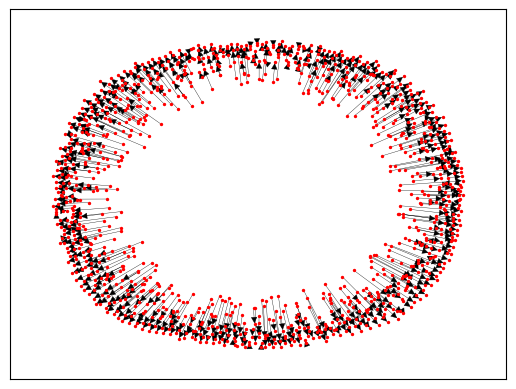

In [63]:
G = nx.DiGraph()
nodes = np.arange(minimum_id, maximum_id).tolist()

G.add_nodes_from(nodes)
G.add_edges_from(s_d_matrix_unique)
nx.draw_networkx(G, arrows = True, node_shape = "o", node_color = "red",with_labels=False, node_size=2, width=0.25)

In [64]:
# node degree calculation
node_indegrees=[item for item in dict(G.in_degree()).items()]
node_outdegrees=[item for item in dict(G.out_degree()).items()]
sorted_indegrees=sorted(node_indegrees,key=operator.itemgetter(1),reverse=True)
sorted_outdegrees=sorted(node_outdegrees,key=operator.itemgetter(1),reverse=True)

print("Sample Indegree List",node_indegrees[:5],"\n")
print("Sorted In Decreasing Order of Indegrees",sorted_indegrees[:5],"\n")
print("Sample Outdegree List",node_outdegrees[:5],"\n")
print("Sorted In Decreasing Order of Outdegree",sorted_outdegrees[:5],"\n")

Sample Indegree List [(0, 1), (1, 1), (2, 1), (3, 1), (4, 0)] 

Sorted In Decreasing Order of Indegrees [(0, 1), (1, 1), (2, 1), (3, 1), (5, 1)] 

Sample Outdegree List [(0, 0), (1, 0), (2, 0), (3, 0), (4, 1)] 

Sorted In Decreasing Order of Outdegree [(4, 1), (7, 1), (8, 1), (9, 1), (12, 1)] 



In [65]:
node_degrees=[item for item in dict(G.degree()).items()]

C:\Users\Jignasu\AppData\Local\Temp\ipykernel_26084\3324095993.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.Series(np.array(node_degrees).T[1], name="Degree distribution"))
C:\Python310\lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<AxesSubplot: xlabel='Degree distribution', ylabel='Density'>

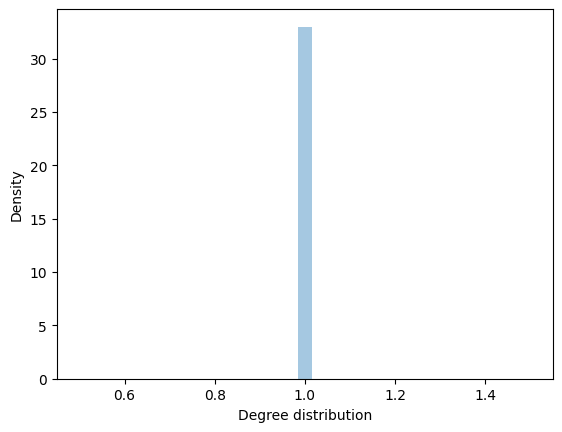

In [66]:
sns.distplot(pd.Series(np.array(node_degrees).T[1], name="Degree distribution"))

Text(0.5, 0, 'Rank')

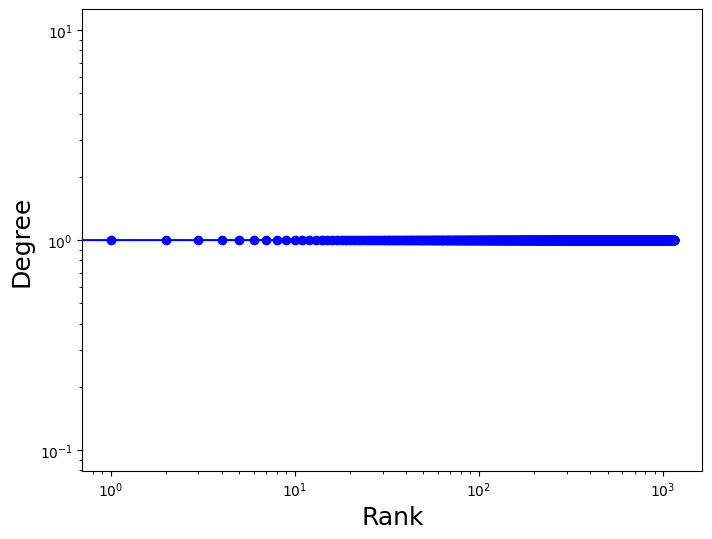

In [67]:
deg=list(sorted(dict(nx.degree(G)).values(),reverse=True)) 
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.loglog(deg,'b-',marker='o')
ax.set_ylabel('Degree',fontsize=18)
ax.set_xlabel('Rank',fontsize=18)

In [68]:
print('Network density:',nx.density(G))

Network density: 0.0004344048653344917


<AxesSubplot: title={'center': 'Closeness centrality scores'}, ylabel='Frequency'>

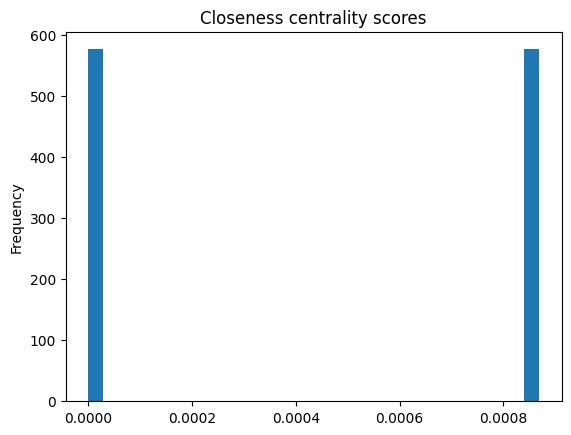

In [69]:
pd.Series(nx.closeness_centrality(G)).sort_values().plot(kind='hist',bins=30,title="Closeness centrality scores")

<AxesSubplot: title={'center': 'Betweenness centrality scores'}, ylabel='Frequency'>

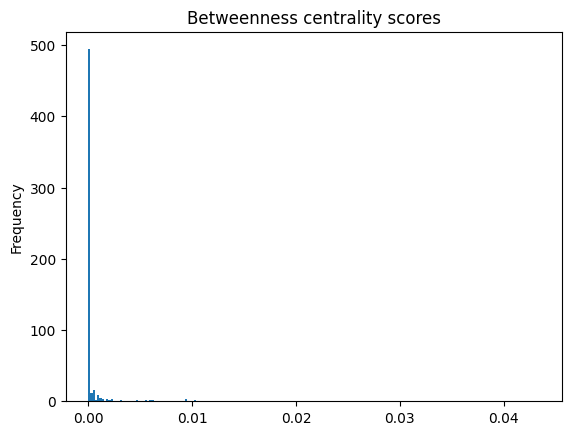

In [70]:
pd.Series(nx.betweenness_centrality(G1)).sort_values().plot(kind='hist',bins=200,title="Betweenness centrality scores")

In [71]:
hubs,authorities=nx.hits(G)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])

Top 10 Biggest Hubs [(784, 0.286749089854576), (304, 0.2497789983999725), (108, 0.2009861689865683), (633, 0.19631686448002023), (902, 0.1776926822785737), (983, 0.16212497205933243), (403, 0.14323962951407068), (391, 0.13949460696406754), (110, 0.13755984669667878), (817, 0.13442149208936485)]

Top 10 Biggest Authorities [(781, 0.28674908985457603), (173, 0.24977899839997253), (919, 0.20098616898656832), (149, 0.19631686448002025), (17, 0.17769268227857374), (927, 0.16212497205933243), (413, 0.1432396295140707), (1, 0.13949460696406757), (1072, 0.1375598466966788), (914, 0.13442149208936488)]


C:\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [86]:
#Creating new distance matrix based on the unique location IDs
dist_y_original = dist_y
dist_y = [0]*max(max(unique_loc_ids.values()))
for y_ids in range(max(max(unique_loc_ids.values()))):
    dist_x = [0]*max(max(unique_loc_ids.values()))
    for x_ids in range(max(max(unique_loc_ids.values()))):
        #print(dist_y_original[ids_to_loc_mapping[y_ids]])
        #print(ids_to_loc_mapping[x_ids])
        dist_x[x_ids] = dist_y_original[s_d_point_dict[ids_to_loc_mapping[y_ids]]][s_d_point_dict[ids_to_loc_mapping[x_ids]]]
    dist_y[y_ids] = dist_x
# print(dist_y)

In [87]:
#Cleaning pickup and drop pair with first and last unique ID in it
#It was creating error in OR-tool, We are tryin to figure out the solution
#Temporarily removing the pairs with first and the last element in them

for pair in s_d_matrix_unique:
    if maximum_id in pair:
        s_d_matrix_unique.remove(pair)
    if minimum_id in pair:
        s_d_matrix_unique.remove(pair)
print(s_d_matrix_unique)

[[783, 866], [784, 781], [785, 438], [786, 395], [787, 992], [788, 1123], [789, 1085], [790, 1101], [791, 944], [792, 242], [793, 712], [486, 1107], [487, 971], [488, 459], [489, 249], [490, 708], [491, 329], [492, 186], [493, 981], [494, 1103], [495, 474], [496, 283], [497, 224], [498, 965], [499, 432], [500, 623], [501, 738], [502, 361], [503, 428], [504, 233], [505, 418], [506, 883], [507, 979], [508, 414], [509, 758], [510, 1029], [511, 252], [512, 722], [513, 613], [514, 1113], [515, 568], [516, 750], [517, 374], [518, 687], [519, 1102], [633, 149], [634, 59], [635, 346], [636, 294], [637, 904], [638, 398], [639, 309], [640, 605], [641, 121], [642, 162], [643, 194], [644, 1008], [645, 210], [646, 204], [73, 141], [74, 11], [75, 991], [76, 772], [77, 864], [78, 32], [79, 775], [80, 297], [827, 464], [292, 704], [1149, 520], [1044, 1051], [1023, 1005], [856, 270], [382, 126], [383, 440], [649, 895], [867, 966], [868, 1020], [869, 426], [870, 582], [666, 985], [667, 19], [35, 463], [

In [ ]:
%%time
"""Simple Pickup Delivery Problem (PDP)."""


from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(dist_y, matrix_pickup_delivery):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = dist_y
    data['pickups_deliveries'] = matrix_pickup_delivery
    data['num_vehicles'] = 80
    data['demands'] = [1]*max(max(unique_loc_ids.values()))
    data['vehicle_capacities'] = [30]*data['num_vehicles']
    data['depot'] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    #print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    vehicles = []
    vehicle_load = []
    vehicle_distance = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        vehicle = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            vehicle.append(node_index)
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        vehicle.append(manager.IndexToNode(index))
        vehicles.append(vehicle)
        vehicle_load.append(route_load)
        vehicle_distance.append(route_distance)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        # print(plan_output)
        total_distance += route_distance
        total_load += route_load
    # print('Total distance of all routes: {}m'.format(total_distance))
    # print('Total load of all routes: {}'.format(total_load))
    return [vehicles, vehicle_load, vehicle_distance]
    
def main123(dist_y, matrix_pickup_delivery):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(dist_y, matrix_pickup_delivery)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    # distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))
    
    # Add Capacity constraint.
    # instead of taking the value from only one matrix we can take calculation of 
    # two matrix which is distance/people
    # people will be pickup drop matrix relted thing so...
    # we take unique trips where nodes do not repeat themselves, but we also put their distnace to be zero in dtance matrix
    # thus computer will know that distance between same place with different name is still zero for accurate result
    # thus creating distance matrix with unique name matrix
    # step 1: create unique trip matrix(figure out a way to rename each trip with unique node name)
    # step 2: create a new distance matrix on its basis
    # step 3: create a function which calculates distance between two nodes in terms of carbon footprint
    # step 4: make it work
    
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    print(solution)
    # Print solution on console.
    if solution:
        vehicles = print_solution(data, manager, routing, solution)
        return vehicles


vehicles = main123(dist_y, s_d_matrix_unique)
print(vehicles[0])
print("\nNumber of people")
print(vehicles[1])
print("\nDistance travelled by the vehicle")
print(vehicles[2])

In [89]:
#Now again merging back unique ids into locations from the results -> vehicles

vehicle_stops = []
for vehicle in vehicles[0]:
    vehicle_stop = []
    for stop in vehicle:
        vehicle_stop.append(ids_to_loc_mapping[stop])
    vehicle_stops.append(vehicle_stop)
print(vehicle_stops)

[[1298, 2127, 2128, 1921, 2026, 2440, 2547, 2754, 2857, 2655, 1932, 2137, 3263, 3161, 3769, 4177, 4282, 4180, 4285, 3978, 3979, 4082, 3364, 3260, 3365, 1821, 1921, 2433, 2326, 1298], [1298, 2326, 2840, 3867, 4074, 4179, 4178, 4079, 3768, 3768, 3766, 3661, 3556, 3555, 3452, 3556, 3555, 4072, 3968, 3762, 3555, 3452, 3659, 3764, 3558, 3665, 3458, 3047, 2326, 1298], [1298, 3556, 3556, 3973, 3973, 3973, 4486, 4692, 4794, 4794, 4691, 4485, 4691, 4485, 4076, 4075, 4176, 4176, 4072, 3971, 3971, 3556, 3660, 3660, 3558, 2846, 2436, 2438, 2126, 1298], [1298, 3062, 4298, 4295, 4295, 4497, 4498, 4497, 4495, 4493, 4491, 4491, 4491, 5006, 5006, 4905, 4802, 4904, 4802, 5008, 5007, 4802, 4699, 4493, 3979, 4083, 3979, 3563, 3255, 1298], [1298, 3763, 3557, 3557, 3763, 3766, 3973, 4488, 4486, 4692, 4898, 5002, 5002, 5002, 4903, 4491, 4388, 3979, 4083, 4290, 4497, 4497, 4497, 4498, 4599, 4498, 4500, 3466, 2326, 1298], [1298, 3763, 3866, 4280, 4487, 4900, 5002, 5002, 4998, 4998, 5513, 5616, 5717, 5820, 5820

In [90]:
#Now removing redundant stops(same stops in order)

unique_vehicle_stops = []
for vehicle_stop in vehicle_stops:
    A = vehicle_stop
    unique_vehicle_stop = [A[i] for i in range(len(A)) if (i==0) or A[i] != A[i-1]]
    unique_vehicle_stops.append(unique_vehicle_stop)
print(unique_vehicle_stops)
         

[[1298, 2127, 2128, 1921, 2026, 2440, 2547, 2754, 2857, 2655, 1932, 2137, 3263, 3161, 3769, 4177, 4282, 4180, 4285, 3978, 3979, 4082, 3364, 3260, 3365, 1821, 1921, 2433, 2326, 1298], [1298, 2326, 2840, 3867, 4074, 4179, 4178, 4079, 3768, 3766, 3661, 3556, 3555, 3452, 3556, 3555, 4072, 3968, 3762, 3555, 3452, 3659, 3764, 3558, 3665, 3458, 3047, 2326, 1298], [1298, 3556, 3973, 4486, 4692, 4794, 4691, 4485, 4691, 4485, 4076, 4075, 4176, 4072, 3971, 3556, 3660, 3558, 2846, 2436, 2438, 2126, 1298], [1298, 3062, 4298, 4295, 4497, 4498, 4497, 4495, 4493, 4491, 5006, 4905, 4802, 4904, 4802, 5008, 5007, 4802, 4699, 4493, 3979, 4083, 3979, 3563, 3255, 1298], [1298, 3763, 3557, 3763, 3766, 3973, 4488, 4486, 4692, 4898, 5002, 4903, 4491, 4388, 3979, 4083, 4290, 4497, 4498, 4599, 4498, 4500, 3466, 2326, 1298], [1298, 3763, 3866, 4280, 4487, 4900, 5002, 4998, 5513, 5616, 5717, 5820, 5614, 5098, 4790, 4689, 4482, 4277, 4071, 3866, 3867, 3762, 3760, 3762, 3557, 1298], [1298, 4083, 4598, 4496, 5013, 51

In [130]:
# pos = nx.circular_layout(G3)
# pos = nx.shell_layout(G3)
# pos = nx.spring_layout(G3)
# pos = nx.planar_layout(G3)
# pos = nx.spectral_layout(G3)
# pos = nx.kamada_kawai_layout(G3)
pos = nx.nx_pydot.graphviz_layout(G3)

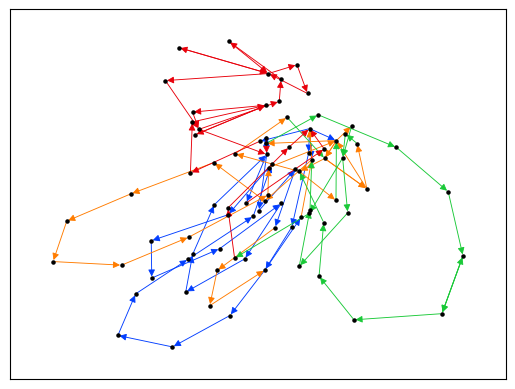

In [140]:
G3 = nx.MultiDiGraph()
active_vehicles = 0

for i in unique_vehicle_stops:
    if(len(i)!=1):
        active_vehicles+=1

# print(sns.color_palette(palette = "bright",n_colors = active_vehicles).as_hex())
pallete = sns.color_palette(palette = "bright",n_colors = active_vehicles).as_hex()

colors = []
edges = []
curr_vehicle = 0
for vehicle_route in unique_vehicle_stops:
    # print(curr_vehicle)
    if curr_vehicle>=active_vehicles:
        break
    prev_stop = vehicle_route[0]
    for stop in vehicle_route[1:]:
        curr_stop = stop
        G3.add_edges_from([(prev_stop, curr_stop)])
        colors.append(pallete[curr_vehicle])
        prev_stop = curr_stop
    curr_vehicle+=1
# fig, ax = plt.subplots(figsize=(25, 25))

nx.draw_networkx(G3, pos = pos,arrows = True, node_shape = "o", edge_color=colors, node_color = "black",with_labels=False, node_size=5, width=0.65)


[]

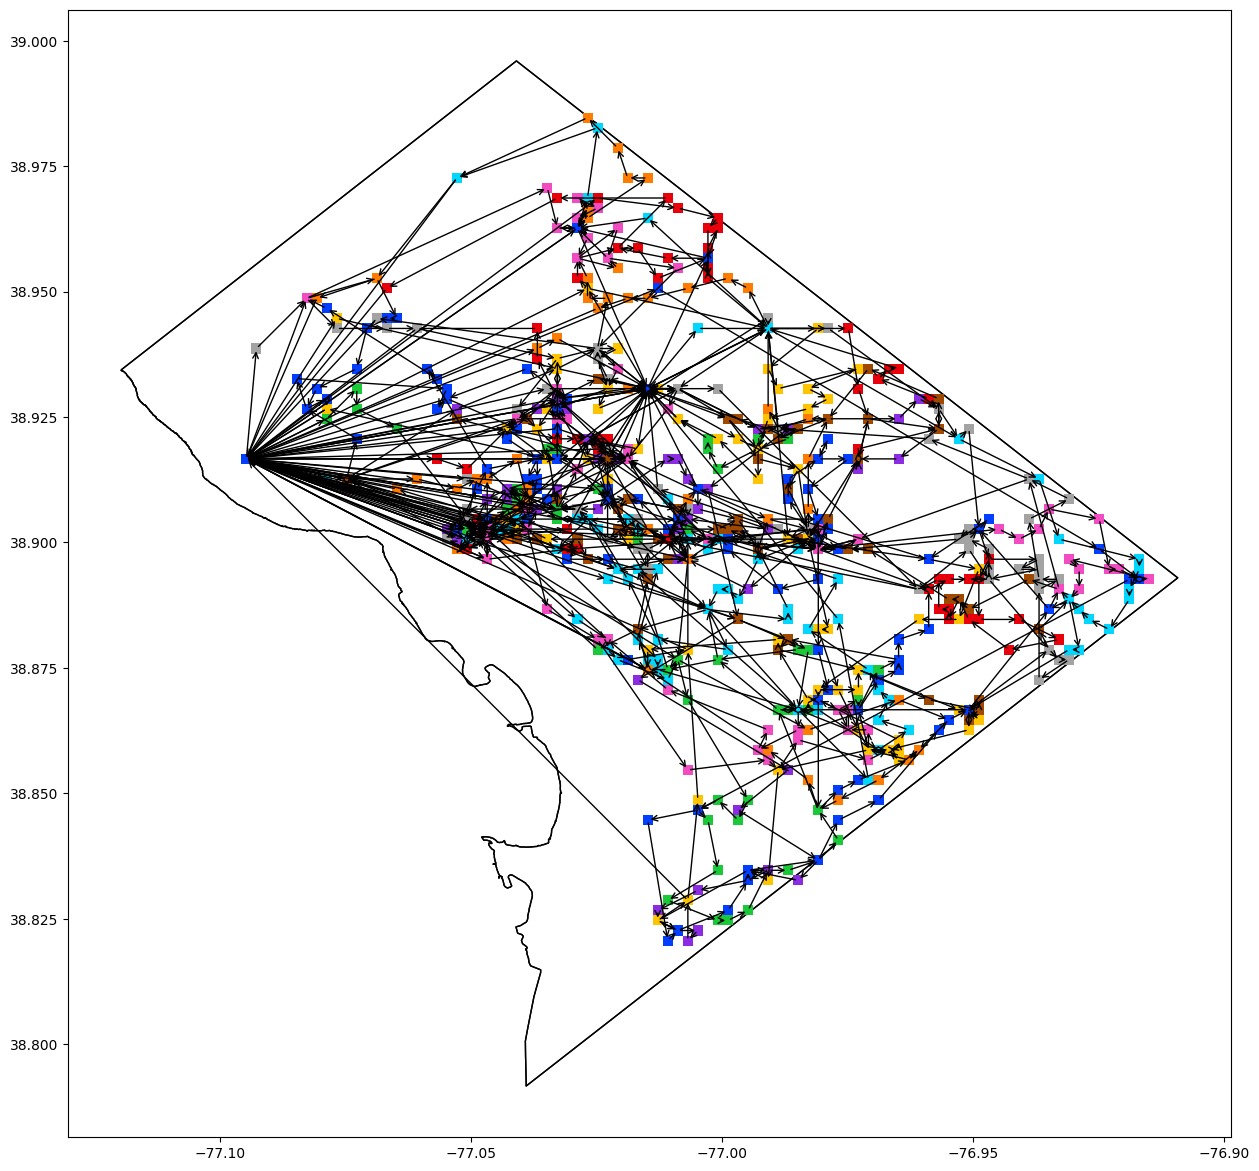

In [180]:
# res_intersection = DC.overlay(grid, how='intersection')
ax = DC.plot(facecolor='none', figsize=(15, 15))
ax = DC.plot(ax=ax, facecolor='none',edgecolor='k')
curr_vehicle = 0

for vehicle_route in unique_vehicle_stops:
    # ax = DC.plot(facecolor='none', figsize=(15, 15))
    # ax = DC.plot(ax=ax, facecolor='none',edgecolor='k')
    # print(curr_vehicle)
    # print(str(pallete[curr_vehicle]))
    if curr_vehicle>=active_vehicles:
    # if curr_vehicle>=1:
        break
    prev_poly = None
    for polygon_index in vehicle_route:
        #print(polygons[polygon_index])
        colored_box = gpd.GeoDataFrame({'geometry':[polygons[polygon_index]]})
        curr_poly = polygons[polygon_index]
        if prev_poly!=None:
            centroid_curr_poly = curr_poly.centroid
            centroid_prev_poly = prev_poly.centroid
            # print("curr_poly = ", centroid_curr_poly.x)
            # print("prev_poly = ", centroid_prev_poly)
            ax.annotate('', xy=(centroid_prev_poly.x, centroid_prev_poly.y), xytext=(centroid_curr_poly.x, centroid_curr_poly.y), arrowprops=dict(arrowstyle="->"), color='k')
        prev_poly = curr_poly
        # color = str(colors[15])
        #print(color)
        ax = colored_box.plot(ax=ax, facecolor=str(pallete[curr_vehicle]),edgecolor='none')
    curr_vehicle+=1
ax.plot(ax=ax)
# plt.savefig("busdata/"+str(curr_vehicle)+"_"+'route.jpg')

# Next plan:

## We need to scale it

### Step1: 
#### make functions which consume and process the data, thus we dont have to re engineer the functions for every different case. 
##### It is working for different cases just by changin the values above.

### Step2: 
#### Make it run and see if the results are coming out or not.
###### Yeas the results are coming as expected

### Step3: 
#### Make calculations and find out the carbon footprint of saved because of it.
###### 



In [181]:
# Caluclate CARBON FOOTPRINT
people_in_the_bus = vehicles[1]
km_travelled_by_the_bus = vehicles[2]
print(people_in_the_bus)
print("Total number of people travelling: "+str(sum(people_in_the_bus)))
print(km_travelled_by_the_bus)


[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 29, 29, 29, 29, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total number of people travelling: 1230
[33, 17, 22, 25, 23, 22, 29, 33, 30, 33, 32, 43, 37, 46, 34, 33, 43, 39, 51, 40, 51, 41, 47, 57, 51, 56, 47, 53, 56, 75, 57, 69, 62, 50, 70, 52, 65, 73, 83, 96, 117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [184]:
carbon_footprint_per_vehicle = list(map(truediv, km_travelled_by_the_bus, people_in_the_bus))
print(carbon_footprint_per_vehicle)

[1.1379310344827587, 0.5862068965517241, 0.7586206896551724, 0.8620689655172413, 0.7931034482758621, 0.7586206896551724, 1.0, 1.1379310344827587, 1.0344827586206897, 1.1379310344827587, 1.103448275862069, 1.4827586206896552, 1.2758620689655173, 1.5862068965517242, 1.1724137931034482, 1.1379310344827587, 1.4827586206896552, 1.3, 1.7586206896551724, 1.3793103448275863, 1.7586206896551724, 1.4137931034482758, 1.6206896551724137, 1.9655172413793103, 1.7586206896551724, 1.9310344827586208, 1.6206896551724137, 1.8275862068965518, 1.9310344827586208, 2.586206896551724, 1.9655172413793103, 2.3793103448275863, 2.1379310344827585, 1.7241379310344827, 2.413793103448276, 1.7333333333333334, 2.2413793103448274, 2.5172413793103448, 2.8620689655172415, 3.310344827586207, 4.0344827586206895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [185]:
#Calculating average carbon footprint per vehicle
carbon_footprint_per_vehicle1 = [i for i in carbon_footprint_per_vehicle if i!=0]
print(carbon_footprint_per_vehicle)
average_carbon_footprint_per_vehicle = sum(carbon_footprint_per_vehicle)/len(carbon_footprint_per_vehicle)


[1.1379310344827587, 0.5862068965517241, 0.7586206896551724, 0.8620689655172413, 0.7931034482758621, 0.7586206896551724, 1.0, 1.1379310344827587, 1.0344827586206897, 1.1379310344827587, 1.103448275862069, 1.4827586206896552, 1.2758620689655173, 1.5862068965517242, 1.1724137931034482, 1.1379310344827587, 1.4827586206896552, 1.3, 1.7586206896551724, 1.3793103448275863, 1.7586206896551724, 1.4137931034482758, 1.6206896551724137, 1.9655172413793103, 1.7586206896551724, 1.9310344827586208, 1.6206896551724137, 1.8275862068965518, 1.9310344827586208, 2.586206896551724, 1.9655172413793103, 2.3793103448275863, 2.1379310344827585, 1.7241379310344827, 2.413793103448276, 1.7333333333333334, 2.2413793103448274, 2.5172413793103448, 2.8620689655172415, 3.310344827586207, 4.0344827586206895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [188]:
print("Average carbon footprint per person per vehicle: "+str(average_carbon_footprint_per_vehicle)+" km")

Average carbon footprint per person per vehicle: 0.857744252873563 km


In [ ]:
# Comparing per vehile per person with taxi carbon footprint
taxi_dist = []
for pickup, drop in matrix_pickup_delivery:
    taxi_dist.append(dist_y[pickup][drop])
print(taxi_dist)

[4, 8, 9, 11, 11, 11, 7, 12, 12, 10, 14, 0, 3, 4, 5, 8, 4, 7, 7, 7, 8, 7, 9, 3, 9, 10, 13, 10, 13, 4, 11, 11, 10, 9, 11, 15, 8, 8, 10, 12, 11, 14, 13, 26, 11, 0, 1, 3, 6, 2, 9, 9, 13, 10, 11, 10, 12, 12, 30, 4, 9, 9, 9, 11, 16, 12, 12, 0, 0, 4, 7, 0, 0, 0, 4, 0, 0, 5, 11, 5, 1, 4, 0, 0, 0, 1, 13, 2, 3, 3, 1, 3, 7, 12, 0, 1, 9, 9, 8, 4, 6, 5, 0, 6, 2, 3, 3, 1, 3, 8, 7, 7, 0, 7, 7, 7, 7, 1, 8, 0, 13, 11, 8, 3, 0, 0, 7, 3, 17, 0, 9, 0, 4, 15, 0, 0, 1, 4, 0, 5, 0, 0, 5, 0, 13, 5, 15, 8, 0, 4, 0, 7, 5, 7, 0, 0, 15, 2, 0, 1, 0, 5, 0, 0, 8, 0, 5, 0, 0, 0, 3, 7, 5, 11, 11, 11, 13, 11, 0, 3, 11, 7, 7, 3, 13, 4, 5, 10, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 6, 0, 2, 7, 9, 3, 4, 2, 6, 5, 6, 6, 0, 8, 9, 5, 0, 0, 7, 3, 1, 0, 5, 7, 2, 0, 0, 9, 8, 8, 6, 0, 4, 10, 14, 8, 7, 1, 2, 0, 2, 0, 1, 11, 7, 5, 5, 0, 0, 3, 0, 6, 9, 13, 7, 7, 0, 0, 0, 4, 3, 0, 8, 0, 2, 7, 0, 3, 0, 4, 2, 7, 5, 4, 5, 2, 2, 3, 3, 3, 12, 0, 0, 9, 0, 0, 3, 4, 12, 11, 8, 4, 5, 5, 0, 2, 6, 0, 0, 8, 7, 0, 0, 0, 7, 6, 3, 8, 0, 7, 6, 11, 11, 0,

In [189]:
average_carbon_footprint_taxi = str(sum(taxi_dist)/len(taxi_dist))
print("Average carbon footprint per person per taxi: "+str(average_carbon_footprint_taxi)+" km")

Average carbon footprint per person per taxi: 6.189236111111111 km


# compare size of the bus and carbon footprint effect

In [ ]:
#find ways to work more on the data

In [47]:
#include number of passengers travelling from stop to stop

In [48]:
#find average bus route size, compare the route size distribution with ours, find power graph in it